In [15]:
#copyright joshuah.rainstar@gmail.com
from __future__ import annotations
import math
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple


def phase_transport_between(curr: torch.Tensor, prev: torch.Tensor, tau: float = 1e-6) -> torch.Tensor:
    B, T, C = curr.shape
    eps = tau

    u = _unit(curr)
    v = _unit(prev)
    w = curr - prev

    c = (u * v).sum(dim=-1, keepdim=True)  # (B,T,1)

    # masks (all as (B,T))
    near_pos = (c > 1.0 - tau).squeeze(-1)           # (B,T)
    near_neg = (c < -1.0 + tau).squeeze(-1)          # (B,T)
    small_u  = (_norm(curr) < tau).squeeze(-1)       # (B,T)  <-- FIX
    small_v  = (_norm(prev) < tau).squeeze(-1)       # (B,T)  <-- FIX
    trivial  = near_pos | small_u | small_v          # (B,T)

    # general branch
    denom  = (1.0 + c).clamp_min(eps)                # (B,T,1)
    a = (v * w).sum(dim=-1, keepdim=True)
    b = (u * w).sum(dim=-1, keepdim=True)
    Kw  = u * a - v * b
    K2w = u * (a * c - b) + v * (b * c - a)
    y_gen = w - Kw + (K2w / denom)                   # (B,T,C)

    # antipodal branch
    if C == 1:
        y_neg = -w
    else:
        v_flat = v.reshape(-1, C)
        p_flat = _orthonormal_perp(v_flat)
        p = p_flat.view(B, T, C)
        proj_v = (v * w).sum(dim=-1, keepdim=True) * v
        proj_p = (p * w).sum(dim=-1, keepdim=True) * p
        y_neg = w - 2.0 * proj_v - 2.0 * proj_p

    # blend (no in-place masked writes)
    y = torch.where(trivial.unsqueeze(-1), w, y_gen)
    y = torch.where(near_neg.unsqueeze(-1), y_neg, y)
    return y

def _norm(v, eps: float = 1e-12):
    return torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)

def _unit(v, eps: float = 1e-12):
    return v / _norm(v, eps)

def _orthonormal_perp(v: torch.Tensor):
    # v: (..., C), returns p ⟂ v, ||p||=1
    *batch, C = v.shape
    flat = v.reshape(-1, C)
    idx = torch.argmin(torch.abs(flat), dim=-1)
    e = torch.zeros_like(flat)
    e.scatter_(1, idx.unsqueeze(1), 1.0)
    proj = (e * flat).sum(dim=-1, keepdim=True) * flat
    p = e - proj
    p = p / _norm(p)
    return p.view(*batch, C)


# ---------- materialize left-aligned centroids at every t for each scale from two trees ----------
def materialize_centroids_from_trees(x: torch.Tensor, levels0, levels1, K: int):
    """
    For each scale W=2^f (f>=1), build mu^{(W)}(t) as the centroid of the left-aligned
    block that contains t. Uses offset-0 tree if block starts at 0 mod W; otherwise offset-1 tree.
    Returns: mu_all: (B, T, K-1, C)   (no scale-1 here; K-1 levels for f=1..K-1)
    """
    B, T, C = x.shape
    device = x.device
    t_idx = torch.arange(T, device=device)  # (T,)
    mus = []
    for f in range(1, K):
        W = 1 << f
        # block start for t: s = floor(t/W)*W
        s = (t_idx // W) * W           # (T,)
        use_offset1 = (s % 2 == 1)     # whether the block start is odd (needs tree-1)
        if f-1 < len(levels0):
            L0 = levels0[f-1]          # (B, N0, C)
            N0 = L0.shape[1]
        else:
            N0 = 0
        if f-1 < len(levels1):
            L1 = levels1[f-1]          # (B, N1, C)
            N1 = L1.shape[1]
        else:
            N1 = 0

        # index within chosen tree:
        # for offset-0 (blocks [0..W-1], [W..2W-1], ...): idx0 = floor(t/W)
        # for offset-1 (blocks [1..W], [W+1..2W], ...):   idx1 = floor((t-1)/W)
        idx0 = (t_idx // W).clamp_max(max(N0-1, 0))
        idx1 = ((t_idx - 1).clamp_min(0) // W).clamp_max(max(N1-1, 0))

        # gather from the two trees
        mu0 = L0.index_select(1, idx0) if N0 > 0 else x.new_zeros(B, T, C)
        mu1 = L1.index_select(1, idx1) if N1 > 0 else x.new_zeros(B, T, C)

        mu = torch.where(use_offset1.view(1, T, 1), mu1, mu0)  # (B,T,C)

        # early region safety: if t < W-1 there is no full left-aligned block yet → zero
        mu = torch.where((t_idx < (W-1)).view(1, T, 1), torch.zeros_like(mu), mu)
        mus.append(mu)
    if len(mus) == 0:
        return x.new_zeros(B, T, 0, C)
    return torch.stack(mus, dim=2)  # (B, T, K-1, C)

class CausalCentroidPyramid(nn.Module):
    """
    Vectorized causal pyramid:
      inputs x: (B, T, C)
      returns deltas: (B, T, K, C)
        where K = 1 (token PT) + (num_scales-1) (cluster PTs)
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        assert num_scales >= 1
        self.K = num_scales
        self.tau = float(tau)

    @torch.no_grad()
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        device = x.device

        # token-level PT (scale-1)
        prev_tok = torch.zeros_like(x)
        if T > 1:
            prev_tok[:, 1:, :] = x[:, :-1, :].contiguous()
        d1 = phase_transport_between(x, prev_tok, tau=self.tau)  # (B,T,C)
        d1[:, :1, :].zero_()  # mask early region (no previous token)

        if self.K == 1:
            return d1.unsqueeze(2)  # (B,T,1,C)

        # Build centroids causally with recursive halves
        mus = []
        mu_prev = x  # μ_0 = x (width=1)
        for s in range(1, self.K):              # s=1..K-1 (width W=2^s)
            W1 = 1 << (s - 1)
            shifted = torch.zeros_like(mu_prev)
            if T > W1:
                shifted[:, W1:, :] = mu_prev[:, :-W1, :].contiguous()  # μ_{s-1}(t - 2^{s-1})

            mu_s = 0.5 * (mu_prev + shifted)     # μ_s(t)
            # zero early region t < W-1
            W = 1 << s
            if W > 1:
                mu_s[:, :W-1, :].zero_()
            mus.append(mu_s)
            mu_prev = mu_s

        mu_all = torch.stack(mus, dim=2) if mus else x.new_zeros(B, T, 0, C)  # (B,T,K-1,C)

        # PT deltas between adjacent causal chunks
        d_list = []
        for j in range(self.K - 1):
            W = 1 << (j + 1)
            prev_mu = torch.zeros_like(mu_all[:, :, j, :])
            if T > W:
                prev_mu[:, W:, :] = mu_all[:, :-W, j, :].contiguous()
            d = phase_transport_between(mu_all[:, :, j, :], prev_mu, tau=self.tau)
            d[:, :W, :].zero_()  # mask early region
            d_list.append(d)

        d_clusters = torch.stack(d_list, dim=2) if d_list else x.new_zeros(B, T, 0, C)
        return torch.cat([d1.unsqueeze(2), d_clusters], dim=2)  # (B,T,K,C)


# ----- STREAMING STATE FOR INFERENCE -----
class CausalPyramidState:
    """
    O(K) step-time updates, no recompute.
    For level ℓ we keep a ring buffer of length 2^ℓ storing μ_ℓ (with μ_0=x).
    That suffices both to:
      - build μ_{ℓ+1}(t) from μ_ℓ(t) and μ_ℓ(t-2^ℓ)
      - compute deltas at scale s=ℓ via μ_s(t-2^s)
    """
    def __init__(self, num_scales: int, C: int, device, batch_size: int = 1, tau: float = 1e-6):
        self.K = num_scales
        self.C = C
        self.B = batch_size
        self.device = device
        self.tau = float(tau)
        self.t = 0  # number of tokens processed so far

        # ring buffers: list over levels ℓ = 0..K-1, each [B, L=2^ℓ, C]
        self.buffers = []
        self.ptrs = []
        for l in range(self.K):
            L = 1 << l
            self.buffers.append(torch.zeros(self.B, L, C, device=device))
            self.ptrs.append(0)

    def _read_lookback(self, level: int, r: int):
        """return μ_level(t - r); zeros if not enough history yet"""
        if self.t < r:
            return torch.zeros(self.B, self.C, device=self.device)
        L = self.buffers[level].size(1)
        idx = (self.ptrs[level] - r) % L
        return self.buffers[level][:, idx, :]

    def _push(self, level: int, value: torch.Tensor):
        """write current μ_level(t) and advance ptr"""
        L = self.buffers[level].size(1)
        self.buffers[level][:, self.ptrs[level], :] = value
        self.ptrs[level] = (self.ptrs[level] + 1) % L

    @torch.no_grad()
    def step(self, x_t: torch.Tensor) -> torch.Tensor:
        """
        x_t: (B, C)
        returns d(t): (B, K, C)  [token PT + (K-1) cluster PTs]
        """
        B, C = x_t.shape
        feats = []

        # ------- token PT (read BEFORE any push) -------
        prev_x = self._read_lookback(level=0, r=1)  # μ0(t-1)
        d1 = phase_transport_between(x_t[:, None, :], prev_x[:, None, :], tau=self.tau).squeeze(1)
        if self.t == 0:
            d1.zero_()
        feats.append(d1)

        # ------- (A) compute all μ_s(t) with pre-push lookbacks -------
        mu_curr = [None] * self.K
        mu_curr[0] = x_t                      # μ0(t)
        mu_prev = x_t
        for s in range(1, self.K):
            W1 = 1 << (s - 1)
            W  = 1 << s
            mu_back = self._read_lookback(level=s-1, r=W1)   # μ_{s-1}(t - 2^{s-1})  (pre-push!)
            mu_s_t  = 0.5 * (mu_prev + mu_back)              # μ_s(t)
            if self.t < (W - 1):                             # early mask (global t)
                mu_s_t.zero_()
            mu_curr[s] = mu_s_t
            mu_prev = mu_s_t

        # ------- (B) compute all deltas d_s using μ_s(t−W) (pre-push) -------
        for s in range(1, self.K):
            W = 1 << s
            mu_prevW = self._read_lookback(level=s, r=W)     # μ_s(t - 2^s)  (pre-push!)
            d_s = phase_transport_between(mu_curr[s][:, None, :], mu_prevW[:, None, :], tau=self.tau).squeeze(1)
            if self.t + 1 <= W:
                d_s.zero_()
            feats.append(d_s)

        # ------- (C) push μ_ℓ(t) for all levels, exactly once -------
        self._push(level=0, value=mu_curr[0])
        for s in range(1, self.K):
            self._push(level=s, value=mu_curr[s])

        self.t += 1
        return torch.stack(feats, dim=1)  # (B, K, C)


class SemanticClusterFeaturesCausal(nn.Module):
    """
    Unified wrapper:
      - forward(x): vectorized for training
      - step(x_t, state): single-step for inference with cache
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        self.pyramid = CausalCentroidPyramid(num_scales=num_scales, tau=tau)
        self.K = num_scales
        self.tau = float(tau)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pyramid(x)  # (B,T,K,C)

    @torch.no_grad()
    def step(self, x_t: torch.Tensor, state: CausalPyramidState) -> torch.Tensor:
        return state.step(x_t)  # (B,K,C)



# ---------------------------
# Small utilities
# ---------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUContextNav(nn.Module):
    def __init__(self, C: int, K: int, dropout: float = 0.0):
        super().__init__()
        self.C, self.K = C, K
        self.W_h = nn.Linear(C, C)
        self.W_r = nn.Linear(C, C)           # computed once (kept as in your spec)
        self.W_z = nn.Linear(C, C)
        self.U_h = nn.ModuleList([nn.Linear(C, C, bias=False) for _ in range(K)])
        self.W_init = nn.Linear(C, C)
        self.U_Z = nn.Linear(C, C, bias=False)
        self.drop = nn.Dropout(dropout)
        self.out_ln = nn.LayerNorm(C)

    def _ensure_seq(self, base, feats):
        """
        Accept:
          base  : (B,C) or (B,T,C)
          feats : (B,K,C) or (B,T,K,C)
        Normalize to:
          base  -> (B,T,C)
          feats -> (B,T,K,C)  (broadcast T if missing)
        """
        squeeze_time = False
        if base.dim() == 2:                    # (B,C) -> (B,1,C)
            base = base[:, None, :]
            squeeze_time = True
        elif base.dim() != 3:
            raise ValueError("base must be (B,C) or (B,T,C)")

        if feats.dim() == 3:                   # (B,K,C) -> (B,1,K,C), will broadcast over T
            feats = feats[:, None, :, :]
        elif feats.dim() != 4:
            raise ValueError("feats must be (B,K,C) or (B,T,K,C)")

        return base, feats, squeeze_time

    def forward(self, base: torch.Tensor, feats: torch.Tensor) -> torch.Tensor:
        base, feats, squeeze_time = self._ensure_seq(base, feats)  # (B,T,C), (B,T,K,C)
        B, T, K, C = feats.size()
        assert K == self.K and C == self.C

        ground   = self.W_h(base)        # (B,T,C)
        criteria = self.W_r(base)        # (B,T,C)  (kept for parity with your sketch)
        state    = self.W_z(base)        # (B,T,C)

        # h_hat stack
        hhat_sum = torch.zeros_like(base)
        for i in range(K):
            ui = self.U_h[i](feats[:, :, i, :])       # (B,T,C)
            hhat_i = torch.tanh(ground + ui)          # (B,T,C)
            hhat_sum = hhat_sum + hhat_i

        initial = self.W_init(self.drop(hhat_sum))    # (B,T,C)

        # reset gate — FIX 1: no extra dimension
        reset = torch.sigmoid(state + initial)        # (B,T,C)

        # h_final with reset — FIX 2: multiply in (B,T,C) space
        h_final = torch.zeros_like(base)
        for i in range(K):
            ui = self.U_h[i](reset * feats[:, :, i, :])   # (B,T,C)
            h_final = h_final + torch.tanh(ground + ui)   # (B,T,C)

        update = torch.sigmoid(state + self.U_Z(initial)) # (B,T,C)
        result = (1.0 - update) * base + update * h_final
        result = self.out_ln(result)

        if squeeze_time:
            result = result[:, 0, :]
        return result

    @torch.no_grad()
    def step(self, base_t: torch.Tensor, feats_t: torch.Tensor) -> torch.Tensor:
        # base_t: (B,C), feats_t: (B,K,C)
        return self.forward(base_t, feats_t)

class GPTSemanticBlock(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        C = config.n_embd
        self.C = C
        self.K = config.n_scales
        self.L = 1 + self.K                    # [K features | base]
        self.features = SemanticClusterFeaturesCausal(num_scales=self.K, tau=1e-6)
        self.drop = nn.Dropout(config.dropout)
        self.ln = nn.LayerNorm(self.C)
        self.nav = GRUContextNav(C=C, K=self.K, dropout=config.dropout)
    
    # vectorized
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,T,C)
        feats = self.features(x)                      # (B,T,K,C)
        return self.nav(x, feats)             # returns (B,T,C)

    # single-step incremental
    @torch.no_grad()
    def step(self, x_t: torch.Tensor, feat_state: CausalPyramidState) -> torch.Tensor:
        feats_t = self.features.step(x_t, feat_state)  # (B,K,C)
        return self.nav.step(x_t, feats_t)           # (B,C)


class FixedEmbedding(nn.Module):
    def __init__(self, config, seed=0):
        super().__init__()
        g = torch.Generator().manual_seed(seed)
        W = torch.randn(config.vocab_size, config.n_embd, generator=g)
        # row-center and row-normalize so rows are zero-mean, unit-norm
        W = W - W.mean(dim=1, keepdim=True)
        W = W / (W.norm(dim=1, keepdim=True) + 1e-8)
        self.weight = nn.Parameter(W, requires_grad=False)

    def forward(self, idx):
        return self.weight[idx]

# ---- BlockFast wired for list-in/list-out mixer ----

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 66 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 6
    n_head:int = 6
    n_embd: int = 128
    n_scales:int = 9
    dropout: float = 0.1

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wte = FixedEmbedding(config),
            h = nn.ModuleList([GPTSemanticBlock(config) for _ in range(config.n_layer)]),
        ))
       
        self.lm_head = nn.Linear(self.config.n_embd, self.config.vocab_size, bias=False)


    # ---------- forward ----------
    def forward(self, idx, targets=None, eprint=False):
        device = idx.device
        b, t = idx.size()
        x = self.transformer.wte(idx) 
        x = x.detach()                 # sever any stale history just in case
        x.requires_grad_(True)         # make x a grad leaf for τ at layer 0

        for block in self.transformer.h:
                x= block(x)
        
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=-1
            )
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss


    @torch.no_grad()
    def generate_greedy(model: nn.Module, idx: torch.LongTensor, max_new_tokens: int, block_size: int):
        """
        model: your GPT with:
           - transformer.wte (embedding)
           - transformer.h : list[GPTSemanticBlock]
           - lm_head
        idx: (B, T0) prompt token ids
        """
        device = next(model.parameters()).device
        B = idx.size(0)
        # per-block feature caches
        feat_states = [CausalPyramidState(model.config.n_scales, model.config.n_embd, device, batch_size=B)
                       for _ in model.transformer.h]
    
        # 1) prime caches with the prompt (causal, one step at a time)
        x_all = model.transformer.wte(idx)  # (B,T0,C); fixed embeddings in your code
        for t in range(idx.size(1)):
            x_t = x_all[:, t, :]
            for blk, st in zip(model.transformer.h, feat_states):
                x_t = blk.step(x_t, st)      # per-block step
            # we discard logits during priming
    
        # 2) roll out new tokens
        out = [idx]
        cur = idx
        for _ in range(max_new_tokens):
            # last token embedding
            last_idx = cur[:, -1]                      # (B,)
            x_t = model.transformer.wte(last_idx)      # (B,C)
            for blk, st in zip(model.transformer.h, feat_states):
                x_t = blk.step(x_t, st)                # (B,C)
            logits = model.lm_head(x_t)                # (B,V)
            next_idx = torch.argmax(logits, dim=-1, keepdim=True)  # greedy; swap to sampling if you like
            out.append(next_idx)
            cur = torch.cat([cur, next_idx], dim=1)
            # keep only last block_size tokens in cur (typical AR convenience)
            if cur.size(1) > block_size:
                cur = cur[:, -block_size:]
        return torch.cat(out, dim=1)

In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [2]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [22]:
# import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap edata (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=8,
    n_embd=128,
    block_size=block_size,
    dropout = 0.2,
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)
model = torch.compile(model)
model = model.to(device)



In [53]:
128/16

8.0

In [23]:

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.339838027954102
3.754626512527466
3.5043158531188965
3.2990241050720215
3.1894378662109375
3.0637221336364746
3.0000500679016113
2.871809482574463
2.810152053833008
2.776656150817871
2.753740072250366
2.7062582969665527
2.618389129638672
2.6193747520446777
2.6118288040161133
2.6136488914489746
2.5816996097564697
2.5041208267211914
2.5206997394561768
2.4914300441741943
2.4512476921081543
2.4798552989959717
2.4363937377929688
2.4631690979003906
2.388073682785034
2.403876543045044
2.429623603820801
2.364198684692383
2.3196892738342285
2.325838088989258
2.332172393798828
2.2986814975738525
2.3013014793395996
2.288130760192871
2.304624319076538
2.275892496109009
2.291836738586426
2.2896318435668945
2.2826147079467773
2.2351841926574707
2.2749063968658447
2.2773799896240234
2.2442641258239746
2.228134870529175
2.208009958267212
2.21307373046875
2.229240894317627
2.1709532737731934
2.178636312484741
2.200833320617676
2.1911468505859375
2.1852409839630127
2.1565299034118652
2.181783199310302

KeyboardInterrupt: 

In [68]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

0.9357731342315674
0.9590237140655518
0.9294271469116211
0.9307587742805481
0.9480361342430115
0.9347789883613586
0.884301483631134
0.8955998420715332
0.9055362939834595
0.9221420884132385
0.8970953822135925
0.9334507584571838
0.9353228807449341
0.9230810403823853
0.8966184258460999
0.8791990280151367
0.8684242963790894
0.9150770902633667
0.8954019546508789
0.9375349283218384
0.8628012537956238
0.9044962525367737
0.9094914197921753
0.9270775318145752
0.910936176776886
0.9039303064346313
0.8960180878639221
0.85153728723526
0.9346643686294556
0.9143067598342896
0.913901686668396
0.8913163542747498
0.8736878037452698
0.922075629234314
0.8823879361152649
0.882016122341156
0.924199104309082
0.9209080338478088
0.9145306348800659
0.9066790342330933
0.9178776741027832
0.895636260509491
0.8606234788894653
0.8950801491737366
0.8849577903747559
0.9114158749580383
0.8999863862991333
0.856029212474823
0.9309101104736328
0.9126245379447937
0.9062104821205139
0.94112628698349
0.9303205609321594
0.901

KeyboardInterrupt: 

In [24]:
total_params = sum(param.numel() for param in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 1860096


In [29]:
# === Validation loader & evaluation ===
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

# NOTE: your config should use the vocab_size loaded from meta.pkl.
# If you accidentally used len(stoi) here, switch to vocab_size.
# config = GPTConfig(vocab_size=vocab_size, ...)

# Build a deterministic-ish validation dataset:
# - p_aligned=1.0 ensures no random jitter offsets
# - jitter=0 disables extra offset entirely
val_dataset = GPUBatchDataset(
    val_ids,
    block_size=block_size,
    batch_size=batch_size,
    device=device,
    jitter=0,
    p_aligned=1.0,
    pad_len=0
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

def evaluate_validation_loss(model, loader, vocab_size, max_steps=200, seed=123):
    """
    Evaluate average cross-entropy loss and perplexity on a subset of the validation set.
    - max_steps: how many batches to average over (caps runtime)
    - seed: sets numpy's RNG so GPUBatchDataset sampling is repeatable across runs
    """
    # Make dataset sampling repeatable (GPUBatchDataset uses np.random)
    import numpy as _np
    _np.random.seed(seed)

    model.eval()
    total_loss = 0.0
    steps = 0

    with torch.no_grad():
        for i, (X, Y) in enumerate(loader):
            # DataLoader(batch_size=1) adds an extra leading dim -> (1, B, T)
            # Squeeze to get (B, T)
            X = X[0]
            Y = Y[0]

            # Forward pass. If your GPT forward returns a tuple, grab logits accordingly.
            logits ,loss = model(X,Y)            # shape expected: (B, T, vocab_size)
            # If your model returns (logits, loss) uncomment the next line and comment the above:


            total_loss += loss.item()
            steps += 1
            if steps >= max_steps:
                break

    avg_loss = total_loss / max(1, steps)
    ppl = math.exp(avg_loss)
    print(f"🧪 Val loss (avg over {steps} steps): {avg_loss:.4f} | Perplexity: {ppl:.2f}")
    return avg_loss, ppl

# === Run it ===
val_loss, val_ppl = evaluate_validation_loss(model, val_loader, vocab_size=vocab_size, max_steps=200, seed=123)


🧪 Val loss (avg over 200 steps): 1.6592 | Perplexity: 5.26


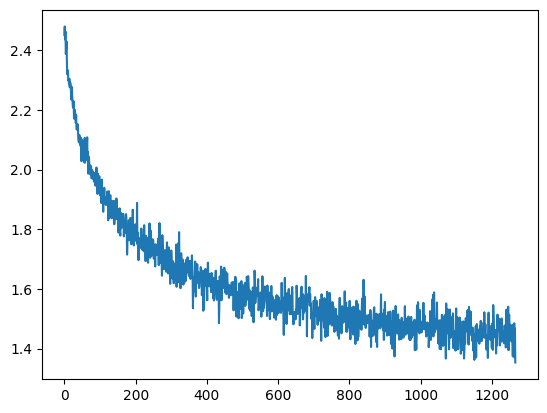

In [25]:
from matplotlib import pyplot as plt
plt.plot(losses[20:])
plt.show()

In [27]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


import torch

def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 pad token: try space, fallback to 0
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # If prompt is longer than block, keep the last block_size chars
    if start_ids.size(1) > max_ctx:
        start_ids = start_ids[:, -max_ctx:]

    # Left-pad to exactly block_size so the first pass sees a full window
    pad_len = max(0, max_ctx - start_ids.size(1))
    if pad_len > 0:
        pad = torch.full((1, pad_len), space_id, dtype=torch.long, device=device)
        idx = torch.cat([pad, start_ids], dim=1)  # shape [1, block_size]
    else:
        idx = start_ids  # already block_size or longer (truncated above)

    initial_pad_len = pad_len  # for stripping at the end

    # generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            context = idx[:, -max_ctx:]  # always feed the last block_size tokens
            logits, _ = model(context, None)
            last_logits = logits[:, -1, :]
            if temperature != 1.0:
                last_logits = last_logits / float(temperature)
            probs = torch.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)  # [1,1]
            idx = torch.cat([idx, next_token], dim=1)

    # drop the initial left-pad when decoding to text
    out_tokens = idx[0, initial_pad_len:].tolist()
    return decode_chars(out_tokens, itos)

    
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)


ROMEO: Juliet, do you love me?  JULIET:
Bet though, he without I was, my bany then reasure else
You shall be paden areths true belot, now now, the matter half us in thy are withend of the king
To you are not end under the this noble
For the house are for proces telous and hand from
The lworn of hand hath preseral shall be hath saide
presed on it.

That thou art a brokes as her some to rose you.

LUCIO:
You sway with the heard of the sicklingbroke,
Which my dead not-friends and that hath be day's be off the times you, fear to long,
For undedieven and Peart in up, beapted for
hold, methought shall in his ripod.

HORTENSIO:
Ay, now, my liege up.

HENRY BOLINGBROKE:
Away, a not the children you are is none.

ANGON:
I will the true, upon my lords, where to have thou must think
Make again till the times
Unly and this the fair?

First Senator:
Her are the duke ut Herefords, and with so,
Or that kin my wise it a dear,--as against what in servelloved the hollow.

MARGARET:
No, forget, from Jut 

In [28]:
import torch
def decode_sequence_char_rapid(
    model, stoi, itos, prompt,
    max_new_tokens=100, block_size=1024,
    temperature=1.0, space_fallback=' '
):
    """
    Fast incremental generator using cached causal features, now matching the
    left-pad-to-block behavior of your regular forward method.
    """
    model.eval()
    device = next(model.parameters()).device
    B = 1

    space_id = stoi.get(space_fallback, 0)
    prompt_ids = encode_chars(prompt, stoi)
    if len(prompt_ids) == 0:
        prompt_ids = [space_id]

    # --- left-pad to block_size to match your regular decode ---
    pad_len = max(0, block_size - len(prompt_ids))
    pad_ids = [space_id] * pad_len
    priming_ids = pad_ids + prompt_ids  # we will NOT include pad_ids in the returned text

    # --- per-block feature caches ---
    feat_states = [
        CausalPyramidState(
            num_scales=model.config.n_scales,
            C=model.config.n_embd,
            device=device,
            batch_size=B,
            tau=1e-6
        ) for _ in model.transformer.h
    ]

    # --- prime caches with padded prompt (no output accumulation for pad) ---
    ids = torch.tensor([priming_ids], dtype=torch.long, device=device)  # (1, T0)
    x_t = None
    for t in range(ids.size(1)):
        idx_t = ids[:, t]
        x_t = model.transformer.wte(idx_t)  # (1,C)
        for blk, st in zip(model.transformer.h, feat_states):
            x_t = blk.step(x_t, st)

    # We'll accumulate only from the true prompt onward
    out = torch.tensor([prompt_ids], dtype=torch.long, device=device)

    # --- incremental rollout ---
    for _ in range(max_new_tokens):
        logits = model.lm_head(x_t)  # (1,V)
        if temperature != 1.0:
            logits = logits / float(temperature)
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)  # (1,1)

        out = torch.cat([out, next_token], dim=1)
        if out.size(1) > block_size:
            out = out[:, -block_size:]  # keep UX identical to regular path

        # advance one step
        tok = next_token.squeeze(-1)     # (1,)
        x_t = model.transformer.wte(tok) # (1,C)
        for blk, st in zip(model.transformer.h, feat_states):
            x_t = blk.step(x_t, st)

    return decode_chars(out[0].tolist(), itos)
    
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO: Juliet, do you love me?  JULIET:"
generated = decode_sequence_char_rapid(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    temperature=0.8
)

print(generated)


Go to word, but my food fear you are broked made;
Which you are word of the traive hath bears.

First Geny sicke and the is arms.

CLARENCE:
The take us took me conty's no well bear so other arm
That the shall bese they chose house us unspled of you,
And theres there strucchs of the gods, and the bersers her bed!

BENVOLIO:
Then, but a sain Paris art the man,
Since to be his shall sir, the sun,
Met the flacting here down wet it,
Thou stand withal! Bust my cries,
Your knows a dear with them.

JULIET:
It is says as my soul, like who say i' tears it you are nor fellow.

PERDIT:
So you wish frell's your grace the watcher'd death;
They in so happy dise of bear myself a sprince!

KING EDWARD IV:
So hearing more he brother: the duke of Since eyes.

LUCIO:

ISABELLA:
O, my lord, they bear of me?

LUCIO:
I am get the hollow, he she excent and night us.

ANGELO:
My lord Servant:
How met's him brother? but me an intent.

HENRY BOLINGBROKE:
Let the time the namples me these where must therefore t

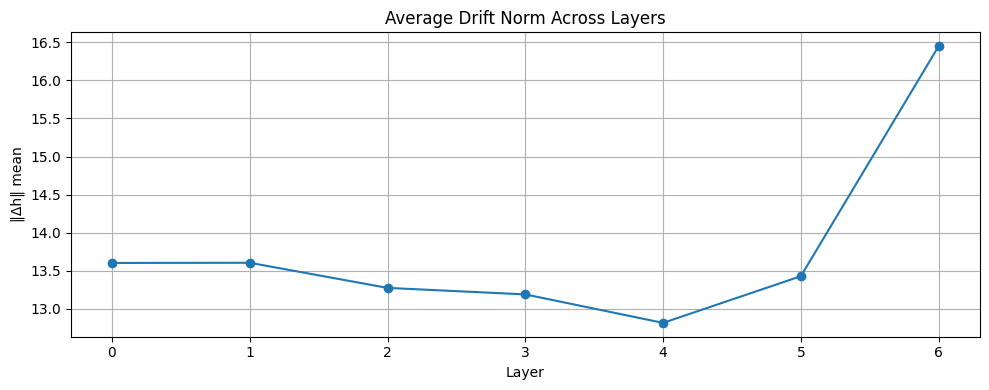

Jacobian rank (final token, projected): 62


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    x = model.transformer.wte(tok)

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = tok_emb
    emb = emb.detach()                 # sever any stale history just in case
    emb.requires_grad_(True)         # make x a grad leaf for τ at layer 0
    def forward_emb(x):
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [32]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    x = model.transformer.wte(tok)
    x = x.detach()                 # sever any stale history just in case
    x.requires_grad_(True)         # make x a grad leaf for τ at layer 0
    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [33]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


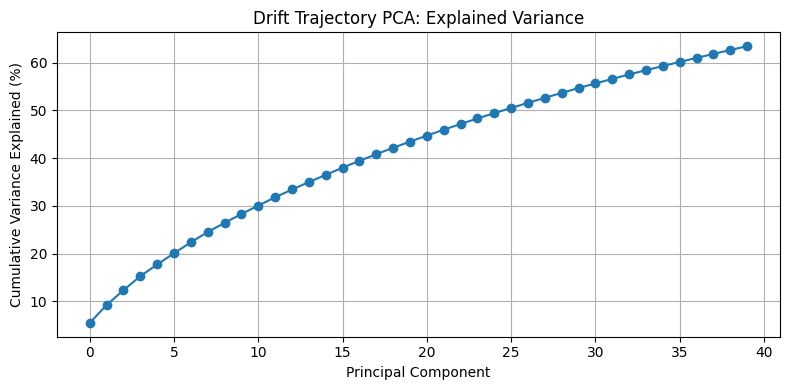

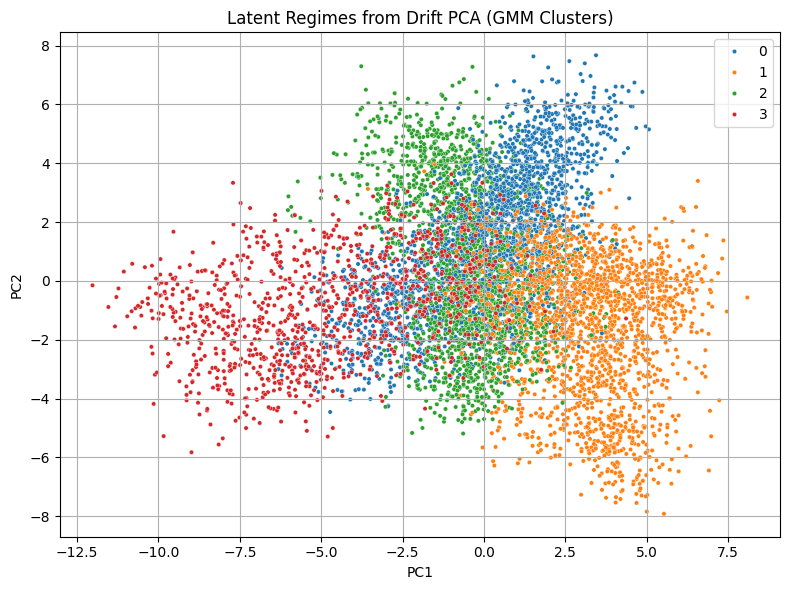

In [34]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)


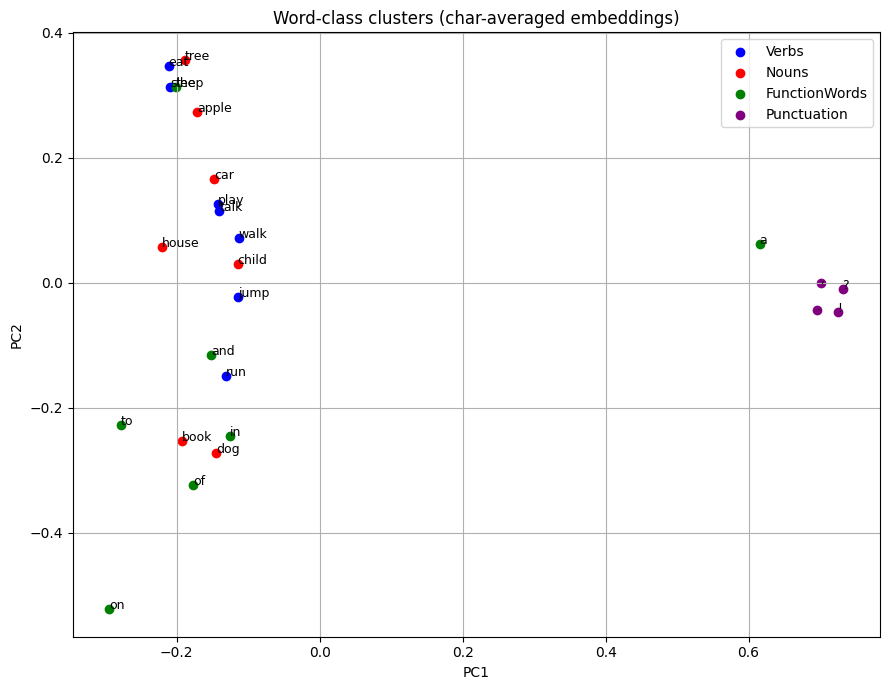

In [35]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [258]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)